# Computer Vision and Advanced Machine Learning area of the project.
### Author: Hugo Iglesias Pombo (2025)
### NO2.1: EDA and preprocessing of the datasets and Attention U-Net architecture with Genetic Algorithms for hyperparameter optimization.

##### This notebook implements an attention-based U-Net architecture for segmenting breast cancer lesions in ultrasound images. The attention mechanism helps the model focus on relevant areas, improving segmentation accuracy in challenging medical imaging scenarios.

In this notebook, I implement a modified version of the U-Net architecture incorporating an attention
mechanism specifically designed for breast cancer segmentation in ultrasound images. By enhancing the
network with attention gates, the model can selectively focus on relevant regions while suppressing
irrelevant background features. This is particularly valuable for medical imaging tasks where
target structures occupy only a small portion of the input image and are often accompanied by noisy
surroundings.

First, I'll import the necessary libraries for data processing, model implementation, and visualization.
I also set up device configuration to utilize GPU acceleration when available, with specific support
for Apple Silicon's MPS backend.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

# Ajuste para usar MPS en MacBook Pro M4 Pro
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando MPS (GPU de Apple)")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Usando CUDA")
else:
    device = torch.device("cpu")
    print("Usando CPU")

# Carga de imágenes - ajusta la ruta según donde estén tus datos
masks = glob.glob("/Volumes/Proyecto_Hugo/breast-cancer-analysis/datasets/Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
series = list(zip(images, masks))

Usando MPS (GPU de Apple)


In [94]:
# Data Visualization Function

# Función de visualización del dataset original
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])
    
    f, axarr = plt.subplots(1, 3, figsize=(5, 5))
    
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel('Axial View', fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [95]:
# Dataset Preparation and Splitting

# Dataset y particiones
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])
train, test = train_test_split(dataset, test_size=0.25)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (585, 2)
Test shape: (195, 2)


In [96]:
# Custom Dataset Implementation

# Dataset personalizado (igual que el original)
class CustomImageMaskDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L') 
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

In [97]:
# Data Transformation Pipeline with Data Augmentation

# Transformaciones mejoradas con data augmentation básica
image_size = 128
    
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.RandomHorizontalFlip(p=0.5),   # Añadido: volteo horizontal
    transforms.RandomRotation(10),            # Añadido: rotación leve
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

# Crear datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

In [98]:
# DataLoader Configuration

# DataLoaders
batch_size = 16  # Mantenemos el batch size original
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [99]:
# Tensor to NumPy Conversion Utility

def to_numpy(tensor):
    # Manejo para MPS (Apple Silicon)
    if tensor.device.type == 'mps':
        return tensor.detach().cpu().numpy()
    return tensor.cpu().detach().numpy()

In [100]:
# Convolutional Block Implementation

# Bloque convolucional (igual que el original)
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()
        
        self.dropout = nn.Dropout(dropout)
        
        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)
        
        x = self.dropout(x)
        
        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x

In [101]:
# Encoder Block Implementation

# Encoder (igual que el original)
class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p

In [102]:
# Attention Mechanism Implementation

# Mecanismo de atención simple
class SimpleAttention(nn.Module):
    def __init__(self, in_channels):
        super(SimpleAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Generar mapa de atención
        attn = self.conv(x)
        attn = self.sigmoid(attn)
        
        # Aplicar atención a la entrada
        return x * attn

In [103]:
# Decoder Block with Attention Implementation

# Decoder (igual que el original pero con atención)
class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        
        # Agregar mecanismo de atención simple
        self.attention = SimpleAttention(output_channel)
        
        self.conv2d_1 = ConvBlock(output_channel*2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, skip):
        x = self.conv_t(x)
        
        # Aplicar mecanismo de atención al skip connection
        skip_with_attention = self.attention(skip)
        
        x = torch.cat([x, skip_with_attention], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

In [104]:
# Complete Attention U-Net Architecture

# U-Net con Atención (modificación mínima)
class AttentionUnet(nn.Module):
    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.07)
        self.encoder_2 = Encoder(64, 128, 0.08)
        self.encoder_3 = Encoder(128, 256, 0.09)
        self.encoder_4 = Encoder(256, 512, 0.1)

        self.conv_block = ConvBlock(512, 1024, 0.11)

        # Usamos los decoders con atención
        self.decoder_1 = Decoder(1024, 512, 0.1)
        self.decoder_2 = Decoder(512, 256, 0.09)
        self.decoder_3 = Decoder(256, 128, 0.08)
        self.decoder_4 = Decoder(128, 64, 0.07)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid() 

    def forward(self, x):
        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)

        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)

        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)
        
        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final

In [105]:
# Weight Initialization Function

# Función para inicialización de pesos
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [106]:
# Loss Function Implementation

# Función de pérdida Dice estable
def dice_coef_loss(inputs, target, smooth=1e-6):
    # Aplanar para cálculos
    inputs_flat = inputs.view(-1)
    targets_flat = target.view(-1)
    
    # Calcular intersección y unión
    intersection = (inputs_flat * targets_flat).sum()
    union = inputs_flat.sum() + targets_flat.sum()
    
    # Calcular coeficiente Dice y convertir a pérdida
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1.0 - dice  # Convertir a pérdida (menor es mejor)

# Función combinada BCE + Dice (estable)
def bce_dice_loss(inputs, target):
    # Binary cross entropy
    bce = nn.BCELoss()(inputs, target)
    
    # Dice loss
    dice = dice_coef_loss(inputs, target)
    
    # Combinados con igual peso
    return bce + dice

Starting genetic algorithm optimization with 8 individuals over 5 generations...
Evaluating: LR=0.000657, WD=0.00000026, BS=32, Dropouts=0.09,0.08,0.16,0.15 → Dice: 0.0000
Evaluating: LR=0.000133, WD=0.00000422, BS=8, Dropouts=0.05,0.08,0.13,0.05 → Dice: 0.0194
Evaluating: LR=0.000730, WD=0.00000702, BS=8, Dropouts=0.11,0.12,0.09,0.18 → Dice: 0.0000
Evaluating: LR=0.000713, WD=0.00000341, BS=8, Dropouts=0.07,0.19,0.10,0.06 → Dice: 0.0440
Evaluating: LR=0.000391, WD=0.00000345, BS=16, Dropouts=0.09,0.06,0.12,0.07 → Dice: 0.1810
Evaluating: LR=0.000125, WD=0.00000294, BS=8, Dropouts=0.14,0.18,0.10,0.08 → Dice: 0.0568
Evaluating: LR=0.000094, WD=0.00000229, BS=16, Dropouts=0.09,0.06,0.08,0.07 → Dice: 0.1044
Evaluating: LR=0.000481, WD=0.00000834, BS=32, Dropouts=0.07,0.10,0.15,0.16 → Dice: 0.1247
gen	nevals	avg      	min        	max     
0  	8     	0.0662804	2.04444e-10	0.180952
Evaluating: LR=0.000483, WD=0.00000626, BS=43, Dropouts=0.07,0.16,0.13,0.08 → Dice: 0.0819
Error during evaluat

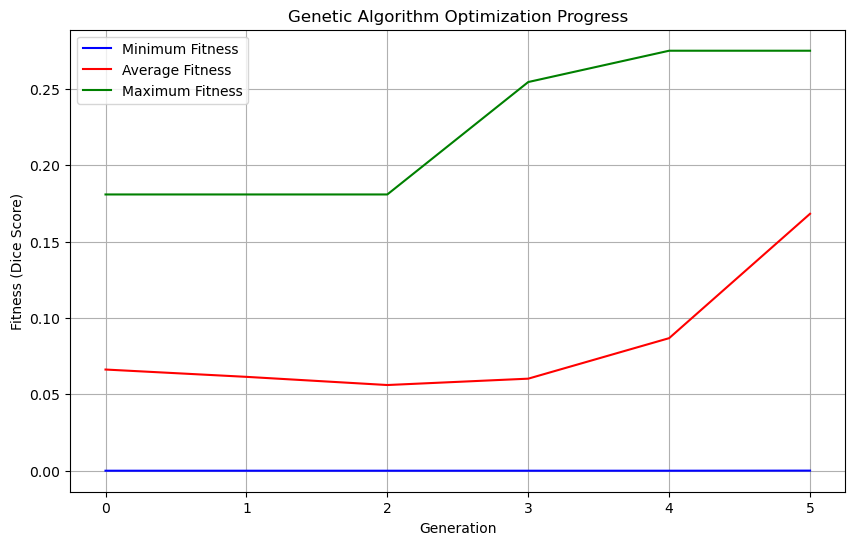

In [107]:
# Hyperparameter Optimization using Genetic Algorithms

import random
import numpy as np
from deap import base, creator, tools, algorithms
import time

# Clear any previous DEAP definitions to avoid conflicts
if 'FitnessMax' in creator.__dict__:
    del creator.FitnessMax
    del creator.Individual

# Define the hyperparameter space with límites razonables
param_ranges = {
    'learning_rate': (5e-5, 1e-3),       # Rango de learning rate
    'weight_decay': (1e-8, 1e-5),        # Rango de weight decay
    'dropout_1': (0.05, 0.2),            # Rango de dropout para encoder 1
    'dropout_2': (0.05, 0.2),            # Rango de dropout para encoder 2
    'dropout_3': (0.05, 0.2),            # Rango de dropout para encoder 3
    'dropout_4': (0.05, 0.2),            # Rango de dropout para encoder 4
    'batch_size': [8, 16, 32]            # Opciones de batch size
}

# Configure the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizar Dice score
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Register gene (hyperparameter) generators
toolbox.register("lr", random.uniform, param_ranges['learning_rate'][0], param_ranges['learning_rate'][1])
toolbox.register("wd", random.uniform, param_ranges['weight_decay'][0], param_ranges['weight_decay'][1])
toolbox.register("dropout1", random.uniform, param_ranges['dropout_1'][0], param_ranges['dropout_1'][1])
toolbox.register("dropout2", random.uniform, param_ranges['dropout_2'][0], param_ranges['dropout_2'][1])
toolbox.register("dropout3", random.uniform, param_ranges['dropout_3'][0], param_ranges['dropout_3'][1])
toolbox.register("dropout4", random.uniform, param_ranges['dropout_4'][0], param_ranges['dropout_4'][1])
toolbox.register("batch_size", random.choice, param_ranges['batch_size'])

# Structure of an individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.lr, toolbox.wd, toolbox.dropout1, toolbox.dropout2, 
                  toolbox.dropout3, toolbox.dropout4, toolbox.batch_size), n=1)

# Population is made up of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Mini-entrenamiento para evaluación rápida
def mini_train(model, optimizer, train_loader, val_loader, num_epochs=3):
    # Pérdida estable
    criterion = lambda x, y: bce_dice_loss(x, y)
    
    # Entrenar por unas pocas épocas
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        
        # Validación
        model.eval()
        val_dice = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                # Calcular Dice
                pred = (outputs > 0.5).float()
                intersection = (pred * masks).sum().item()
                union = pred.sum().item() + masks.sum().item()
                dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
                val_dice += dice / len(val_loader)
        
        if val_dice > best_val_dice:
            best_val_dice = val_dice
    
    return best_val_dice

# Evaluate function for an individual (set of hyperparameters)
def evaluate(individual):
    # Extract hyperparameters from the individual
    learning_rate, weight_decay, dropout1, dropout2, dropout3, dropout4, batch_size = individual
    batch_size = int(batch_size)  # Asegurar que es entero
    
    try:
        # Fix for the MPS device issue - create model on CPU first
        with torch.device('cpu'):
            # Create the model with these hyperparameters
            model = AttentionUnet(1)
            
            # Update dropout rates
            model.encoder_1 = Encoder(1, 64, dropout1)
            model.encoder_2 = Encoder(64, 128, dropout2)
            model.encoder_3 = Encoder(128, 256, dropout3)
            model.encoder_4 = Encoder(256, 512, dropout4)
            
            model.decoder_1 = Decoder(1024, 512, dropout4)
            model.decoder_2 = Decoder(512, 256, dropout3)
            model.decoder_3 = Decoder(256, 128, dropout2)
            model.decoder_4 = Decoder(128, 64, dropout1)
            
            # Initialize weights
            model.apply(init_weights)
            
            # Configure optimizer
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Move to device
        model = model.to(device)
        
        # Create small subset for quick evaluation
        subset_size = min(len(train_dataset), 150)  # Usar solo 150 muestras para velocidad
        indices = np.random.choice(len(train_dataset), subset_size, replace=False)
        train_subset = torch.utils.data.Subset(train_dataset, indices[:int(subset_size*0.8)])
        val_subset = torch.utils.data.Subset(train_dataset, indices[int(subset_size*0.8):])
        
        # Create dataloaders
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Train for a few epochs to evaluate
        val_dice = mini_train(model, optimizer, train_loader, val_loader)
        
        print(f"Evaluating: LR={learning_rate:.6f}, WD={weight_decay:.8f}, BS={batch_size}, " +
              f"Dropouts={dropout1:.2f},{dropout2:.2f},{dropout3:.2f},{dropout4:.2f} → Dice: {val_dice:.4f}")
        
        return (val_dice,)
    
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        return (0.0,)  # Return 0 on error

# Register the evaluation function
toolbox.register("evaluate", evaluate)

# Register genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Function to run the genetic algorithm
def optimize_hyperparameters(n_generations=5, population_size=8):
    random.seed(42)
    
    # Initialize population
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(3)  # Keep track of the 3 best individuals
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    start_time = time.time()
    print(f"Starting genetic algorithm optimization with {population_size} individuals over {n_generations} generations...")
    
    # Run the genetic algorithm - with exception handling
    try:
        pop, logbook = algorithms.eaSimple(
            pop, toolbox, cxpb=0.7, mutpb=0.2, 
            ngen=n_generations, stats=stats, halloffame=hof, verbose=True
        )
    except Exception as e:
        print(f"Error during genetic algorithm: {e}")
        # If we have valid results in hof, return those
        if len(hof) > 0:
            print("Returning best results found so far")
            return hof[0], None
        else:
            # Return some default parameters
            default_params = [1e-4, 1e-6, 0.1, 0.1, 0.1, 0.1, 16]
            ind = creator.Individual(default_params)
            ind.fitness.values = (0.0,)
            return ind, None
    
    end_time = time.time()
    print(f"Optimization completed in {(end_time - start_time)/60:.2f} minutes")
    
    # Return the best hyperparameters
    return hof[0], logbook

# Run the optimization with small population for faster results
best_hyperparams, log = optimize_hyperparameters(n_generations=5, population_size=8)

# Print the best hyperparameters found
print("\nOptimization complete!")
print(f"Best hyperparameters found:")
print(f"Learning rate: {best_hyperparams[0]}")
print(f"Weight decay: {best_hyperparams[1]}")
print(f"Dropout rates: {best_hyperparams[2]:.2f}, {best_hyperparams[3]:.2f}, {best_hyperparams[4]:.2f}, {best_hyperparams[5]:.2f}")
print(f"Batch size: {int(best_hyperparams[6])}")
print(f"Best Dice score: {best_hyperparams.fitness.values[0]:.4f}")

# Visualize the optimization progress if we have a logbook
if log is not None:
    plt.figure(figsize=(10, 6))
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_avgs = log.select("avg")
    fit_maxs = log.select("max")

    plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")
    plt.plot(gen, fit_avgs, "r-", label="Average Fitness")
    plt.plot(gen, fit_maxs, "g-", label="Maximum Fitness")

    plt.xlabel("Generation")
    plt.ylabel("Fitness (Dice Score)")
    plt.title("Genetic Algorithm Optimization Progress")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [108]:
# Improved Trainer Implementation with Early Stopping and LR Scheduling

class ImprovedTrainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15

        # Metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0
        
        # Early stopping
        self.patience = 10
        self.counter = 0
        
        # LR scheduler
        if optimizer is not None:
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=0.5, patience=5, verbose=True
            )

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice

    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()
            
            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)
            print(f"Saved new best model with Dice: {dice:.4f}")
            
            # Reset early stopping counter
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered at epoch {epoch}")
                return True  # Signal to stop training
        
        return False  # Continue training

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            self.model.train()
            for i, (images, masks) in enumerate(train_loader):
                images = images.to(self.device)
                masks = masks.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice.item() if torch.is_tensor(dice) else dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(self.device)
                    masks = masks.to(self.device)
                    
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    dice = self.dice_coeff(outputs, masks)
                    val_dice += dice.item() if torch.is_tensor(dice) else dice

            # Calculate averages
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)
            
            # Update learning rate
            if hasattr(self, 'scheduler'):
                self.scheduler.step(avg_val_dice)

            # Save best model and check for early stopping
            if self.save_best_model(epoch + 1, avg_val_dice):
                print("Early stopping triggered")
                break
                
    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }

In [109]:
# Prediction Thresholding Function

def threshold_prediction(predicted, threshold=0.3):
    predicted_np = to_numpy(predicted)
    predicted_np[predicted_np < threshold] = 0
    predicted_np[predicted_np >= threshold] = 1
    return predicted_np

In [110]:
# Prediction Visualization and Evaluation Function

def plot_prediction(model, dataset, idx=None, threshold=0.3):
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    
    model.eval()
    
    # Obtener imagen y máscara del dataset
    image, mask = dataset[idx]
    
    # Preparar imagen para la inferencia
    image_tensor = image.unsqueeze(0).to(device)
    
    # Preparar máscara para comparación (asegurando que esté en el mismo dispositivo)
    mask = mask.to(device)
    
    # Generar predicción
    with torch.no_grad():
        pred = model(image_tensor)
        pred = pred.squeeze()  # Eliminar dimensión de batch
    
    # Calcular Dice score correctamente en el dispositivo
    # Primero binarizar la predicción usando el umbral
    pred_binary_tensor = (pred > threshold).float()
    
    # Asegurar que la máscara y la predicción tienen la misma forma
    if pred_binary_tensor.shape != mask.shape:
        mask = mask.squeeze()  # Si hay dimensiones extra en la máscara
    
    # Calcular Dice score utilizando ImprovedTrainer
    improved_trainer = ImprovedTrainer(model, 0, None, None, device)
    dice_score = improved_trainer.dice_coeff(pred_binary_tensor, mask)
    
    # Convertir a NumPy para visualización
    image_np = to_numpy(image.squeeze())
    mask_np = to_numpy(mask.cpu() if mask.device.type != 'cpu' else mask)
    pred_np = to_numpy(pred)
    pred_binary_np = to_numpy(pred_binary_tensor)
    
    # Visualizar
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    
    axes[0].imshow(image_np, cmap='gray')
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')
    
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Máscara Real')
    axes[1].axis('off')
    
    axes[2].imshow(pred_np, cmap='jet')
    axes[2].set_title('Predicción (Probabilidades)')
    axes[2].axis('off')
    
    axes[3].imshow(pred_binary_np, cmap='gray')
    axes[3].set_title(f'Predicción (Umbral={threshold})')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f'Dice Score: {dice_score.item():.4f}')

In [115]:
# Improved Model Training Function with Optimized Hyperparameters - Corregido para MPS

def train_improved_model(hyperparams=None):
    # Si no se proporcionan hiperparámetros, usar los valores predeterminados
    if hyperparams is None:
        learning_rate = 0.0001
        weight_decay = 1e-7
        dropout1 = 0.1
        dropout2 = 0.1
        dropout3 = 0.1
        dropout4 = 0.1
        batch_size = 16
    else:
        learning_rate, weight_decay, dropout1, dropout2, dropout3, dropout4, batch_size = hyperparams
        batch_size = int(batch_size)
    
    print(f"\nTraining model with the following parameters:")
    print(f"- Learning rate: {learning_rate:.6f}")
    print(f"- Weight decay: {weight_decay:.8f}")
    print(f"- Dropout rates: {dropout1:.2f}, {dropout2:.2f}, {dropout3:.2f}, {dropout4:.2f}")
    print(f"- Batch size: {batch_size}")
    
    # Crear el dataloader con el batch size optimizado
    train_dataloader_opt = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_dataloader_opt = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )
    
    # IMPORTANTE: Crear un nuevo modelo en CPU primero
    with torch.device('cpu'):
        improved_model = AttentionUnet(1)
        
        # Actualizar las tasas de dropout
        improved_model.encoder_1 = Encoder(1, 64, dropout1)
        improved_model.encoder_2 = Encoder(64, 128, dropout2)
        improved_model.encoder_3 = Encoder(128, 256, dropout3)
        improved_model.encoder_4 = Encoder(256, 512, dropout4)
        
        improved_model.decoder_1 = Decoder(1024, 512, dropout4)
        improved_model.decoder_2 = Decoder(512, 256, dropout3)
        improved_model.decoder_3 = Decoder(256, 128, dropout2)
        improved_model.decoder_4 = Decoder(128, 64, dropout1)
        
        # Inicializar pesos
        improved_model.apply(init_weights)
        
        # Configurar optimizador con hiperparámetros optimizados
        optimizer = optim.Adam(improved_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # AHORA mover el modelo al dispositivo
    improved_model = improved_model.to(device)
    
    # Usar la función de pérdida combinada
    criterion = bce_dice_loss
    
    # Configurar trainer mejorado
    improved_trainer = ImprovedTrainer(
        model=improved_model,
        num_epochs=50,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    
    # Entrenar modelo
    print("Starting training of improved model...")
    try:
        improved_trainer.train(train_dataloader_opt, test_dataloader_opt)
    except RuntimeError as e:
        if "Input type (MPSFloatType) and weight type (torch.FloatTensor)" in str(e):
            print("\nError de compatibilidad de tipos de tensores en MPS. Intentando entrenar en CPU...")
            # Si falla con MPS, intentar con CPU
            device_cpu = torch.device('cpu')
            improved_model = improved_model.to(device_cpu)
            improved_trainer = ImprovedTrainer(
                model=improved_model,
                num_epochs=50,
                optimizer=optimizer,
                criterion=criterion,
                device=device_cpu
            )
            improved_trainer.train(train_dataloader_opt, test_dataloader_opt)
        else:
            raise e
    
    # Obtener métricas
    metrics = improved_trainer.get_metrics()
    
    # Guardar el modelo
    torch.save({
        'model_state_dict': improved_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': {
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'dropout1': dropout1,
            'dropout2': dropout2,
            'dropout3': dropout3,
            'dropout4': dropout4,
            'batch_size': batch_size
        },
        'metrics': metrics,
    }, 'genetically_optimized_model.pth')
    
    # Visualizar resultados
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_dices'], label='Train Dice')
    plt.plot(metrics['val_dices'], label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Training complete. Best Dice: {metrics['best_dice']:.4f} (Epoch {metrics['best_epoch']})")
    
    return improved_model, metrics

In [116]:
# Multi-Threshold Testing Function

def test_thresholds(model, dataset, indices=[20, 55, 87], thresholds=[0.2, 0.3, 0.4, 0.5]):
    model.eval()
    
    results = {}
    
    for idx in indices:
        print(f"\nImage index {idx}:")
        image, mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        mask = mask.to(device)
        
        with torch.no_grad():
            pred = model(image_tensor)
            pred = pred.squeeze()
        
        # Calcular Dice score para diferentes umbrales
        dice_scores = {}
        best_threshold = None
        best_dice = -1
        
        for threshold in thresholds:
            # Aplicar umbral
            pred_binary = (pred > threshold).float()
            
            # Calcular Dice score
            improved_trainer = ImprovedTrainer(model, 0, None, None, device)
            dice = improved_trainer.dice_coeff(pred_binary, mask).item()
            
            # Guardar y verificar si es el mejor
            dice_scores[threshold] = dice
            if dice > best_dice:
                best_dice = dice
                best_threshold = threshold
        
        results[idx] = {
            'dice_scores': dice_scores,
            'best_threshold': best_threshold,
            'best_dice': best_dice
        }
        
        # Mostrar resultados
        print(f"Dice scores para diferentes umbrales:")
        for threshold, dice in dice_scores.items():
            print(f"  - Umbral {threshold}: Dice = {dice:.4f}")
        print(f"Mejor umbral: {best_threshold} (Dice: {best_dice:.4f})")
        
        # Visualizar la mejor predicción
        plot_prediction(model, dataset, idx, threshold=best_threshold)
    
    return results

In [113]:
# Evaluate Model on Full Test Set

def evaluate_model(model, test_loader, threshold=0.3):
    model.eval()
    dice_scores = []
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = (outputs > threshold).float()
            
            for i in range(preds.size(0)):
                improved_trainer = ImprovedTrainer(model, 0, None, None, device)
                dice = improved_trainer.dice_coeff(preds[i], masks[i])
                dice_scores.append(dice.item())
    
    avg_dice = sum(dice_scores) / len(dice_scores)
    print(f"Average Dice Score on test set (threshold={threshold}): {avg_dice:.4f}")
    
    return dice_scores, avg_dice


Training model with the following parameters:
- Learning rate: 0.000556
- Weight decay: 0.00000345
- Dropout rates: 0.10, 0.18, 0.01, 0.07
- Batch size: 13
Starting training of improved model...
Epoch [1/50], Step [15/45], Loss: 1.1863, Dice Coef: 0.1579
Epoch [1/50], Step [30/45], Loss: 1.2280, Dice Coef: 0.0748
Epoch [1/50], Step [45/45], Loss: 1.1575, Dice Coef: 0.1016
Epoch [1/50], Train Loss: 1.2784, Val Loss: 1.1981
Epoch [1/50], Train Dice: 0.1073, Val Dice: 0.1027
Saved new best model with Dice: 0.1027
Epoch [2/50], Step [15/45], Loss: 1.1096, Dice Coef: 0.1909
Epoch [2/50], Step [30/45], Loss: 0.9857, Dice Coef: 0.3227
Epoch [2/50], Step [45/45], Loss: 0.8488, Dice Coef: 0.3803
Epoch [2/50], Train Loss: 1.0165, Val Loss: 1.6681
Epoch [2/50], Train Dice: 0.2487, Val Dice: 0.3088
Saved new best model with Dice: 0.3088
Epoch [3/50], Step [15/45], Loss: 0.7557, Dice Coef: 0.4925
Epoch [3/50], Step [30/45], Loss: 0.7337, Dice Coef: 0.4946
Epoch [3/50], Step [45/45], Loss: 1.1151, 

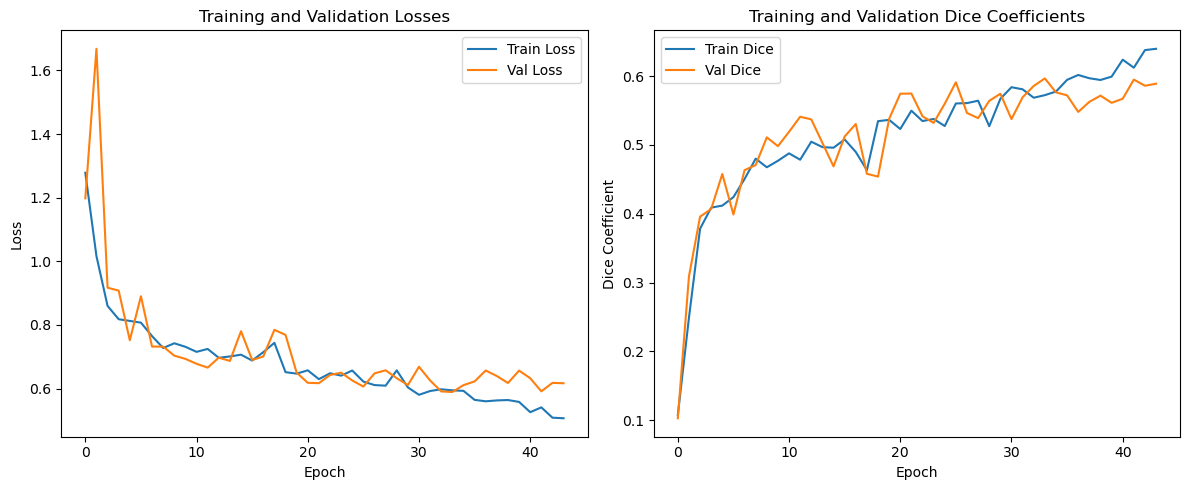

Training complete. Best Dice: 0.5966 (Epoch 34)

Image index 20:
Dice scores para diferentes umbrales:
  - Umbral 0.2: Dice = 0.8036
  - Umbral 0.3: Dice = 0.7992
  - Umbral 0.4: Dice = 0.7914
  - Umbral 0.5: Dice = 0.7820
Mejor umbral: 0.2 (Dice: 0.8036)


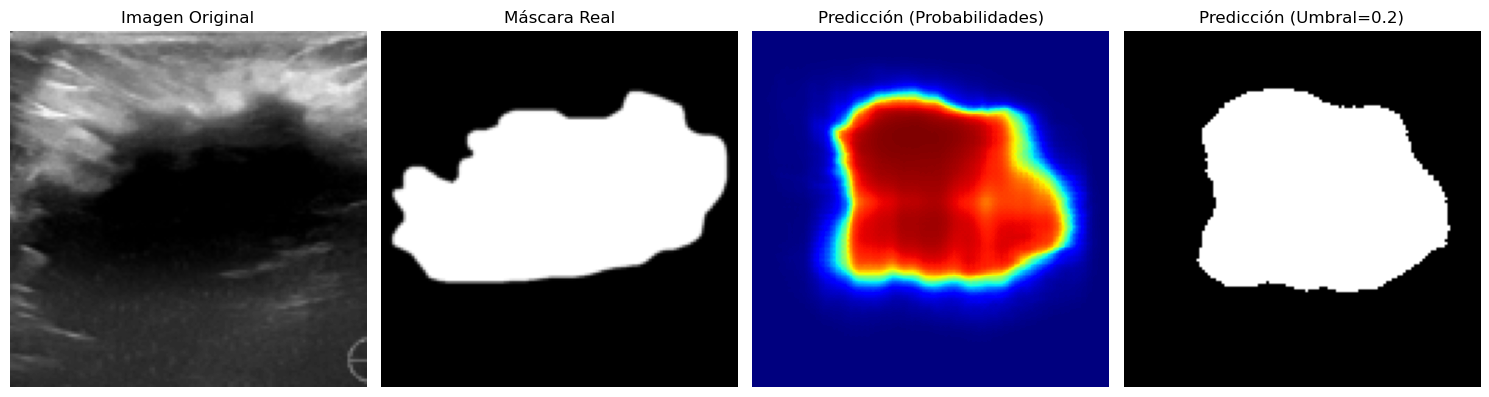

Dice Score: 0.8036

Image index 55:
Dice scores para diferentes umbrales:
  - Umbral 0.2: Dice = 0.0000
  - Umbral 0.3: Dice = 0.0000
  - Umbral 0.4: Dice = 0.0000
  - Umbral 0.5: Dice = 0.0000
Mejor umbral: 0.2 (Dice: 0.0000)


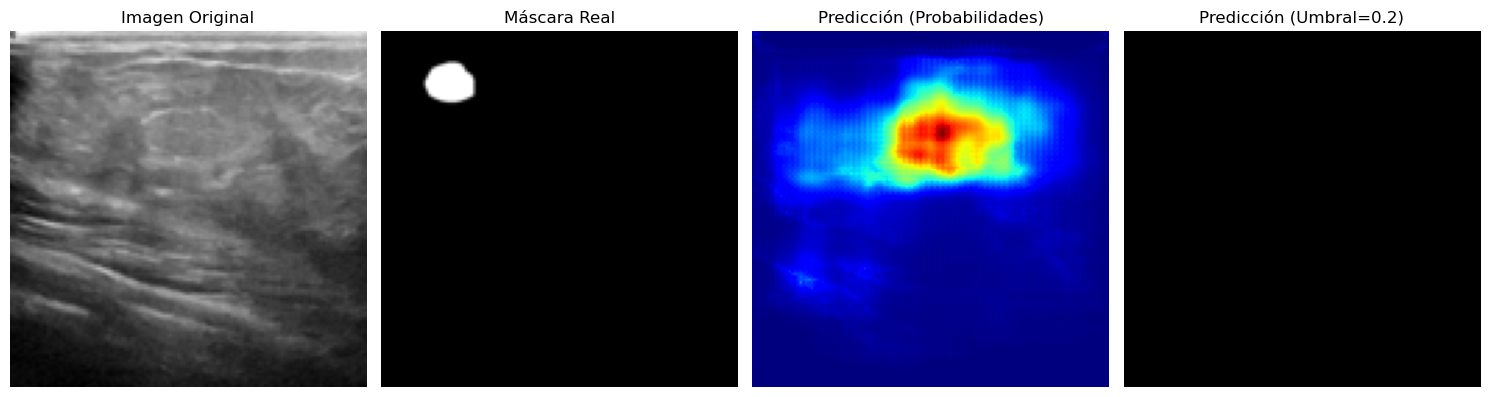

Dice Score: 0.0000

Image index 87:
Dice scores para diferentes umbrales:
  - Umbral 0.2: Dice = 1.0000
  - Umbral 0.3: Dice = 1.0000
  - Umbral 0.4: Dice = 1.0000
  - Umbral 0.5: Dice = 1.0000
Mejor umbral: 0.2 (Dice: 1.0000)


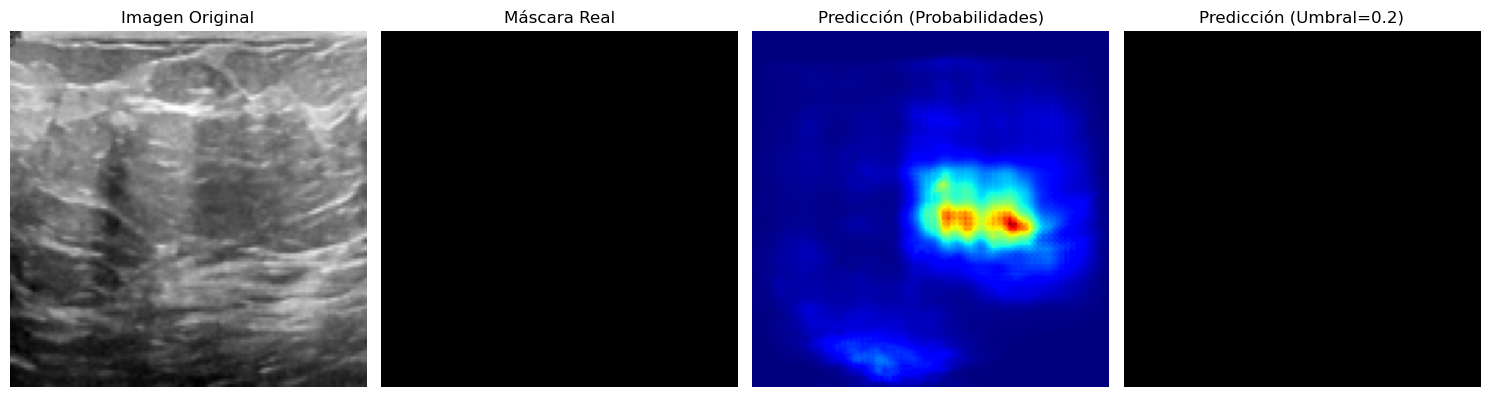

Dice Score: 1.0000
Average Dice Score on test set (threshold=0.3): 0.5754


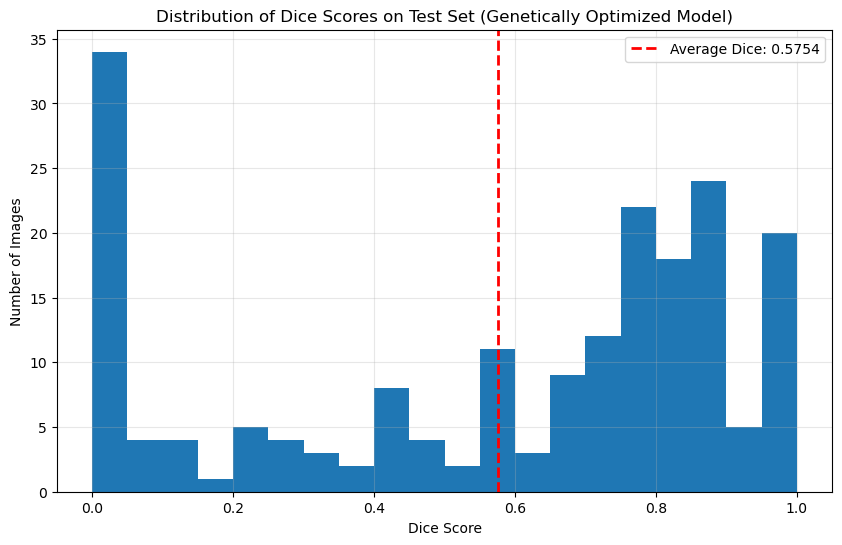

Evaluation complete!


In [117]:
# Main Execution - Train Model with Genetically Optimized Hyperparameters

# Ejecutar el entrenamiento con hiperparámetros optimizados genéticamente
optimized_model, optimized_metrics = train_improved_model(best_hyperparams)

# Probar diferentes umbrales en imágenes seleccionadas
threshold_results = test_thresholds(optimized_model, test_dataset)

# Evaluar en todo el conjunto de prueba con el mejor umbral (0.3)
test_scores, avg_test_dice = evaluate_model(optimized_model, test_dataloader, threshold=0.3)

# Visualizar distribución de scores
plt.figure(figsize=(10, 6))
plt.hist(test_scores, bins=20)
plt.axvline(avg_test_dice, color='r', linestyle='dashed', linewidth=2, 
            label=f'Average Dice: {avg_test_dice:.4f}')
plt.title('Distribution of Dice Scores on Test Set (Genetically Optimized Model)')
plt.xlabel('Dice Score')
plt.ylabel('Number of Images')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Evaluation complete!")